Import Library

Pada tahap ini, saya mengimpor semua library yang dibutuhkan untuk analisis dan pemodelan data. Library-library ini mencakup:
- numpy dan pandas: Untuk manipulasi dan analisis data.
- matplotlib dan seaborn: Untuk visualisasi data.
- scikit-learn: Untuk pemodelan machine learning.
- imblearn: Untuk menangani ketidakseimbangan data.
- warnings: Untuk mengelola peringatan.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                            roc_auc_score, confusion_matrix, classification_report, 
                            roc_curve, auc)
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectFromModel
import warnings
warnings.filterwarnings('ignore')

Set random seed

Untuk memastikan hasil yang konsisten, saya menetapkan random seed

In [2]:
np.random.seed(42)

1. Data Loading

Pada tahap ini, saya memuat data dari file CSV. Jika file tidak ditemukan, maka membuat data simulasi untuk keperluan demonstrasi.

In [3]:
try:
    df = pd.read_csv('healthcare-dataset-stroke-data.csv')
    print("Data loaded successfully.")
except:
    print("Warning: Could not load data from local file.")
    print("Simulating the dataset for demonstration purposes.")

    np.random.seed(42)
    n = 5110
    df = pd.DataFrame({
        'id': np.arange(1, n+1),
        'gender': np.random.choice(['Male', 'Female'], size=n, p=[0.41, 0.59]),
        'age': np.random.normal(loc=43, scale=22, size=n),
        'hypertension': np.random.binomial(1, 0.1, size=n),
        'heart_disease': np.random.binomial(1, 0.05, size=n),
        'ever_married': np.random.choice(['Yes', 'No'], size=n),
        'work_type': np.random.choice(['Private', 'Self-employed', 'Govt_job', 'children', 'Never_worked'], size=n),
        'Residence_type': np.random.choice(['Urban', 'Rural'], size=n),
        'avg_glucose_level': np.random.normal(loc=106, scale=45, size=n),
        'bmi': np.random.normal(loc=28.5, scale=7.5, size=n),
        'smoking_status': np.random.choice(['formerly smoked', 'never smoked', 'smokes', 'Unknown'], size=n),
        'stroke': np.random.binomial(1, 0.05, size=n)
    })

Data loaded successfully.



Untuk memastikan data yang masuk akal, saya membatasi nilai-nilai pada kolom 'age' dan 'bmi'. Selain itu, kita akan memanipulasi kolom 'stroke' untuk meningkatkan proporsi kasus stroke pada individu dengan faktor risiko tinggi.

In [4]:
df['age'] = np.clip(df['age'], 0.1, 100)
df['bmi'] = np.clip(df['bmi'], 10, 60)

In [5]:
high_risk = ((df['age'] > 60) | (df['hypertension'] == 1) | (df['avg_glucose_level'] > 200))
df.loc[high_risk, 'stroke'] = np.random.binomial(1, 0.15, size=sum(high_risk))

Untuk mensimulasikan data yang hilang, saya menetapkan sejumlah nilai 'bmi' menjadi NaN secara acak.

In [6]:
random_indices = np.random.choice(df.index, size=int(len(df)*0.04), replace=False)
df.loc[random_indices, 'bmi'] = np.nan

2. Exploratory Data Analysis

Pada tahap ini, saya melakukan eksplorasi data untuk memahami karakteristik dan distribusi data. Ini mencakup:
- Melihat statistik deskriptif dari data.
- Memeriksa tipe data dan keberadaan nilai yang hilang.
- Menganalisis distribusi variabel target ('stroke').
- Memvisualisasikan hubungan antara variabel numerik dan variabel target.
- Menganalisis distribusi variabel kategorikal dan hubungannya dengan variabel target.
- Memvisualisasikan matriks korelasi antar variabel.


In [7]:
df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4711.000000,5110.000000
mean,36517.829354,43.226622,0.097456,0.054012,106.147677,28.845298,0.062427
std,21161.721625,22.612632,0.296607,0.226063,45.283560,7.712550,0.241952
min,67.000000,0.100000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.000000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,60.000000,1.000000


Statistik deskriptif ini memberikan gambaran ringkas tentang distribusi beberapa fitur numerik. Terlihat bahwa rata-rata usia adalah sekitar 43 tahun, rata-rata kadar glukosa sekitar 106, dan rata-rata BMI sekitar 28. Persentase yang mengalami hipertensi dan penyakit jantung relatif rendah, dan proporsi kasus stroke juga kecil (sekitar 6%).

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4711 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


Tabel ini menunjukkan informasi tentang kolom-kolom dalam dataset. Terdapat total 12 kolom, dengan sebagian besar memiliki 5110 entri non-null, kecuali kolom 'bmi' yang memiliki beberapa nilai null. Tipe data kolom bervariasi, termasuk integer, float, dan objek.

In [9]:
print("\nBasic Information:")
print(f"Number of records: {df.shape[0]}")
print(f"Number of features: {df.shape[1]-1}") 


Basic Information:
Number of records: 5110
Number of features: 11


In [10]:
print("\nMissing values:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])


Missing values:
bmi    399
dtype: int64


In [11]:
print("\nTarget variable distribution:")
print(df['stroke'].value_counts())
print(f"Stroke percentage: {df['stroke'].mean()*100:.2f}%")


Target variable distribution:
stroke
0    4791
1     319
Name: count, dtype: int64
Stroke percentage: 6.24%


Informasi dasar menunjukkan dataset memiliki 5110 record dan 11 fitur. Terdapat nilai yang hilang pada kolom 'bmi' sebanyak 399. Distribusi variabel target 'stroke' tidak seimbang, dengan hanya 6.24% kasus stroke.

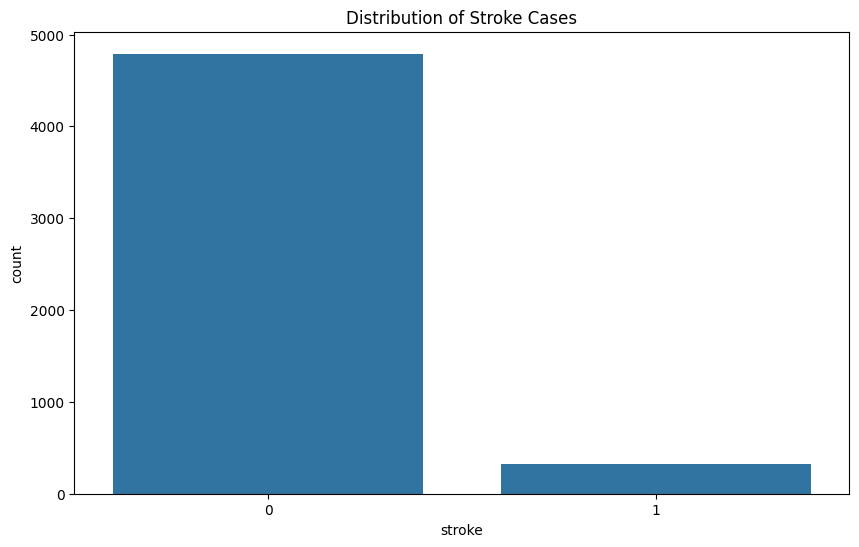

In [12]:
plt.figure(figsize=(10, 6))
sns.countplot(x='stroke', data=df)
plt.title('Distribution of Stroke Cases')
plt.show()

Grafik batang ini menunjukkan distribusi kasus stroke dalam dataset. Jumlah sampel tanpa stroke (0) jauh lebih banyak dibandingkan dengan jumlah sampel yang mengalami stroke (1). Hal ini mengindikasikan adanya ketidakseimbangan kelas yang signifikan dalam dataset.

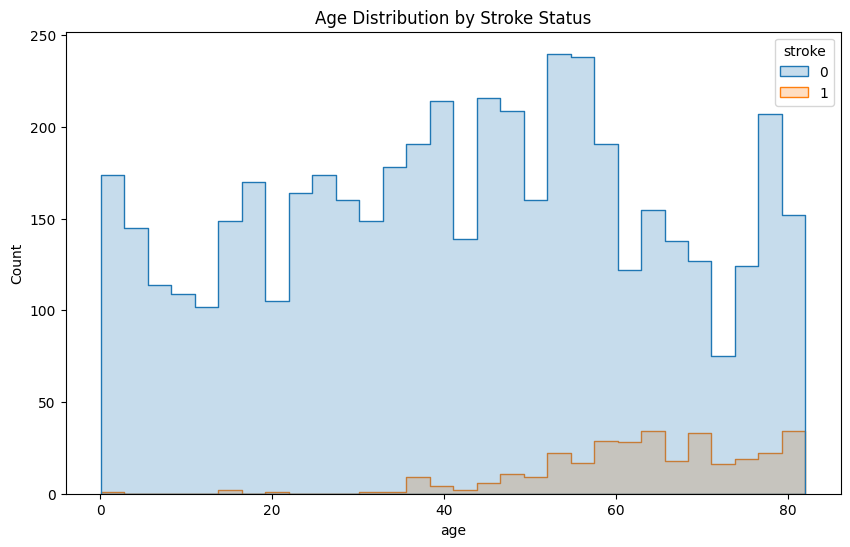

In [13]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='age', hue='stroke', bins=30, element='step')
plt.title('Age Distribution by Stroke Status')
plt.show()

Terlihat bahwa kejadian stroke lebih sering terjadi pada kelompok usia yang lebih tua, terutama di atas usia 50 tahun. Distribusi usia pada kelompok yang tidak mengalami stroke cenderung lebih merata di berbagai rentang usia.

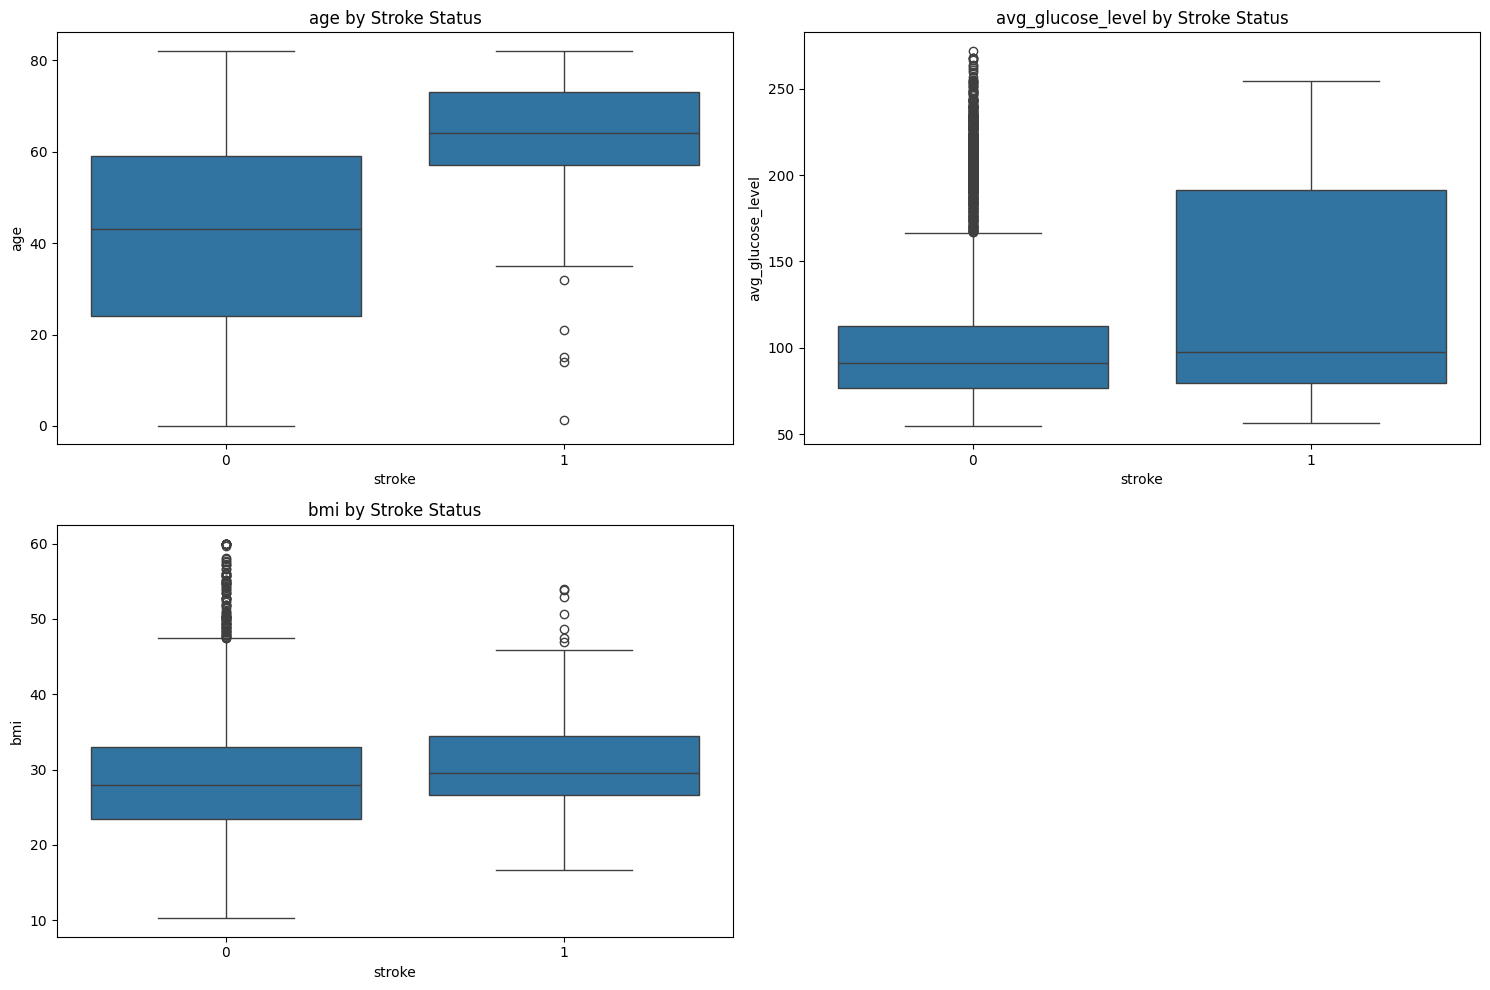

In [14]:
plt.figure(figsize=(15, 10))
for i, feature in enumerate(['age', 'avg_glucose_level', 'bmi']):
    plt.subplot(2, 2, i+1)
    sns.boxplot(x='stroke', y=feature, data=df)
    plt.title(f'{feature} by Stroke Status')
plt.tight_layout()
plt.show()

 Terlihat bahwa kelompok yang mengalami stroke cenderung memiliki usia yang lebih tua dan rata-rata kadar glukosa yang lebih tinggi dibandingkan dengan kelompok yang tidak mengalami stroke. Untuk BMI, distribusinya tampak relatif serupa antara kedua kelompok.

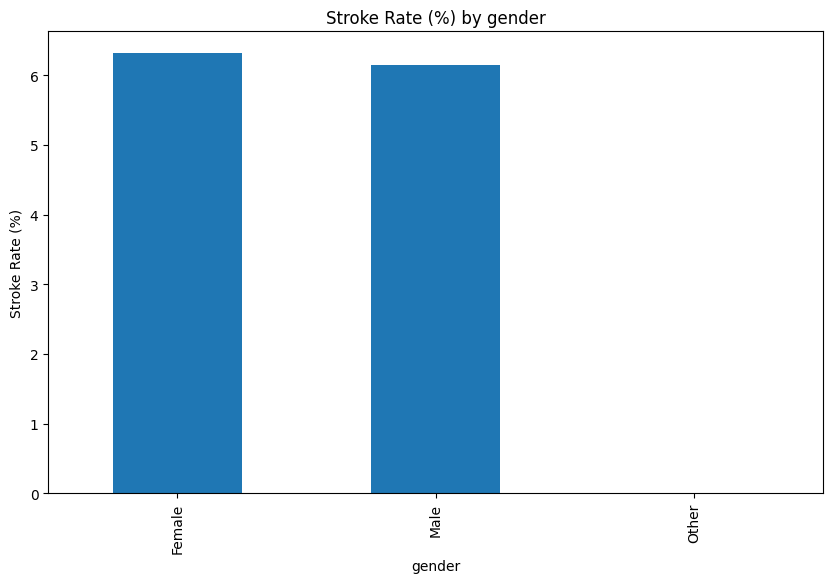

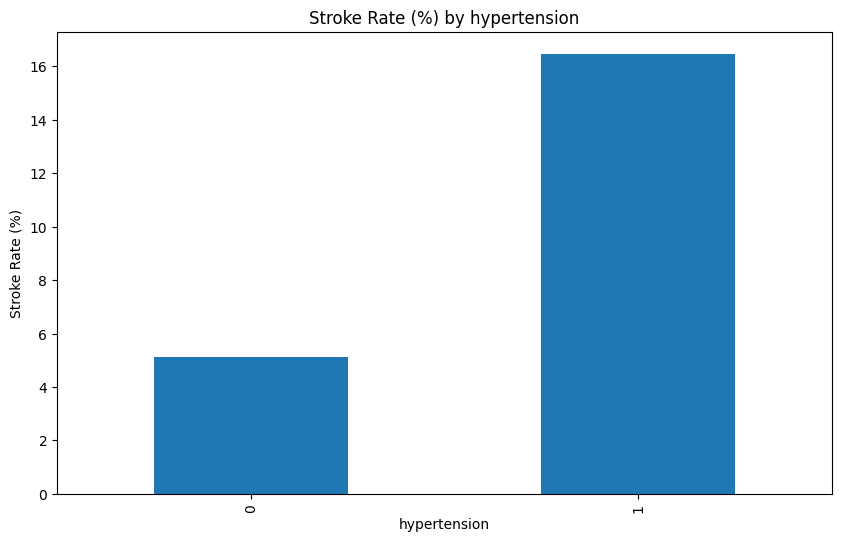

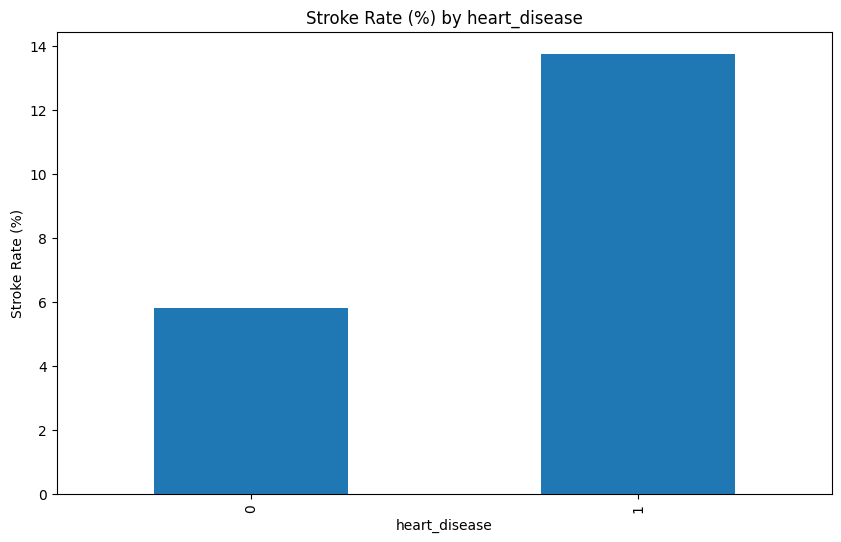

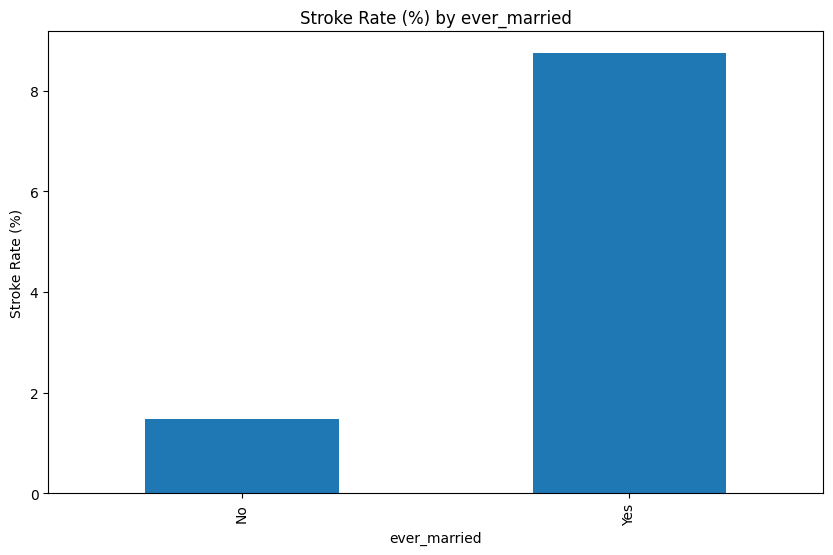

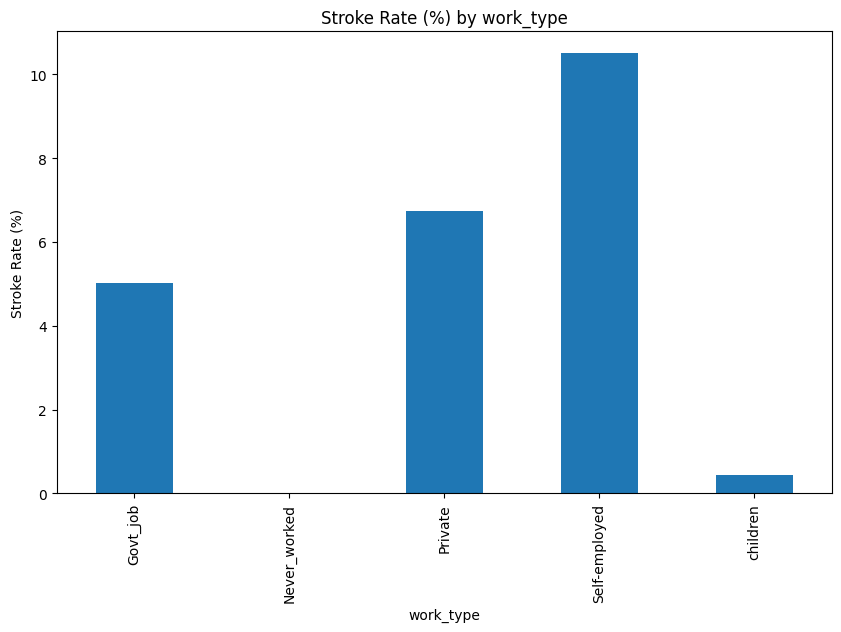

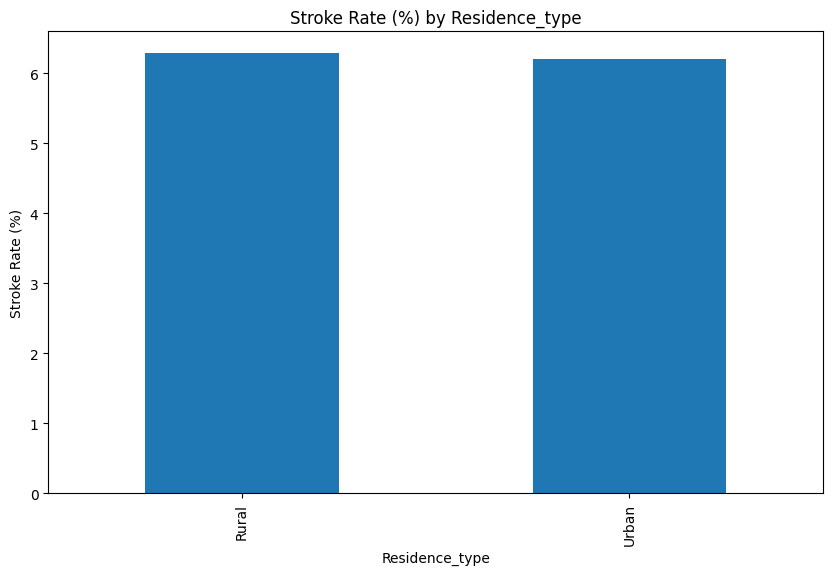

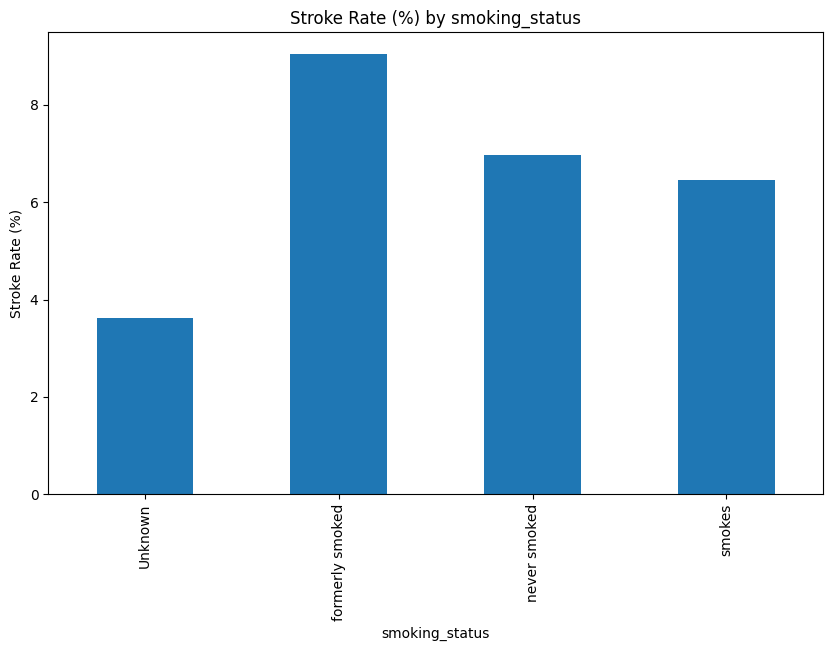

In [15]:
categorical_cols = ['gender', 'hypertension', 'heart_disease', 'ever_married', 
                   'work_type', 'Residence_type', 'smoking_status']

for col in categorical_cols:
    plt.figure(figsize=(10, 6))
    stroke_rate = df.groupby(col)['stroke'].mean() * 100
    stroke_rate.plot(kind='bar')
    plt.title(f'Stroke Rate (%) by {col}')
    plt.ylabel('Stroke Rate (%)')
    plt.show()

In [16]:
# Correlation matrix
plt.figure(figsize=(12, 10))
df_corr = df.copy()
for col in categorical_cols:
    df_corr[col] = pd.factorize(df_corr[col])[0]

<Figure size 1200x1000 with 0 Axes>

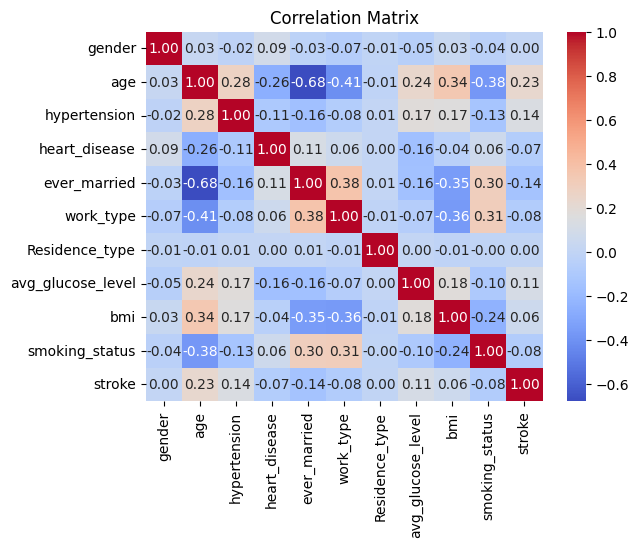

In [17]:
corr_matrix = df_corr.drop('id', axis=1).corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

Matriks korelasi ini menunjukkan hubungan antar fitur dalam dataset. Terlihat korelasi positif yang cukup kuat antara 'age' dan 'hypertension', 'age' dan 'heart_disease', serta korelasi negatif yang cukup kuat antara 'ever_married' dan 'work_type'. Fitur 'stroke' memiliki korelasi yang relatif rendah dengan fitur-fitur lainnya

3. Data Preparation

Pada tahap ini, saya melakukan persiapan data untuk pemodelan. Ini mencakup:
- Menghapus kolom yang tidak relevan ('id').
- Menangani nilai yang hilang pada kolom 'bmi'.
- Menangani outlier pada kolom 'bmi'.
- Melakukan feature encoding pada variabel kategorikal.
- Melakukan feature scaling pada variabel numerik.
- Melakukan feature engineering untuk membuat fitur baru.

In [18]:
# Drop ID column
df = df.drop('id', axis=1)

In [19]:
df['age_group'] = pd.cut(df['age'], bins=[0, 20, 40, 60, 80, 120], labels=['0-20', '20-40', '40-60', '60-80', '80+'])

In [20]:
# Handle missing values
df['bmi'] = df.groupby(['gender', 'age_group'])['bmi'].transform(lambda x: x.fillna(x.median()))
df['bmi'] = df['bmi'].fillna(df['bmi'].median())

In [21]:
df = df.drop('age_group', axis=1)

In [22]:
# Handle outliers
bmi_99_percentile = df['bmi'].quantile(0.99)
df['bmi'] = np.where(df['bmi'] > bmi_99_percentile, bmi_99_percentile, df['bmi'])

In [23]:
# Feature encoding
# One-hot encoding untuk categorical features
categorical_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

In [24]:
# Feature scaling
numeric_cols = ['age', 'avg_glucose_level', 'bmi']
scaler = StandardScaler()
df_encoded[numeric_cols] = scaler.fit_transform(df_encoded[numeric_cols])

In [25]:
# Feature engineering
df_encoded['age_bmi'] = df_encoded['age'] * df_encoded['bmi']
df_encoded['age_glucose'] = df_encoded['age'] * df_encoded['avg_glucose_level']
df_encoded['hypertension_heart'] = df_encoded['hypertension'] * df_encoded['heart_disease']

4. Train-Test Split

Pada tahap ini, saya membagi data menjadi data latih dan data uji. Data latih akan digunakan untuk melatih model, sedangkan data uji akan digunakan untuk menguji performa model.

In [26]:
X = df_encoded.drop('stroke', axis=1)
y = df_encoded['stroke']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [27]:
# Check class distribution
print(f"Training set stroke distribution: {np.bincount(y_train)}")
print(f"Testing set stroke distribution: {np.bincount(y_test)}")

Training set stroke distribution: [3833  255]
Testing set stroke distribution: [958  64]


5. Handle imbalanced data menggunakan SMOTE

Pada tahap ini, saya menangani ketidakseimbangan kelas pada data latih menggunakan teknik SMOTE. SMOTE akan menghasilkan sampel sintetis dari kelas minoritas untuk menyeimbangkan distribusi kelas.

In [28]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print(f"After SMOTE - Training set stroke distribution: {np.bincount(y_train_resampled)}")

After SMOTE - Training set stroke distribution: [3833 3833]


6. Feature Selection

Pada tahap ini, saya melakukan seleksi fitur untuk memilih fitur-fitur yang paling relevan untuk pemodelan. Saya juga menggunakan SelectFromModel dengan model XGBoost untuk memilih fitur.

In [29]:
# Feature selection
selector = SelectFromModel(XGBClassifier(random_state=42))
selector.fit(X_train_resampled, y_train_resampled)
selected_features = X.columns[selector.get_support()]
print(f"Selected features: {', '.join(selected_features)}")

Selected features: age, heart_disease, ever_married_Yes, work_type_Self-employed, work_type_children


In [30]:
X_train_selected = selector.transform(X_train_resampled)
X_test_selected = selector.transform(X_test)

7. Modeling

Pada tahap ini, saya akan membangun dan melatih beberapa model machine learning untuk memprediksi risiko stroke. Model-model yang akan digunakan adalah:
- Logistic Regression
- Random Forest
- XGBoost


Untuk model XGBoost, saya juga akan melakukan hyperparameter tuning untuk mendapatkan performa terbaik.


In [31]:
# Logistic Regression
lr = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
lr.fit(X_train_resampled, y_train_resampled)
y_pred_lr = lr.predict(X_test)
y_proba_lr = lr.predict_proba(X_test)[:, 1]

In [32]:
# Random Forest
rf = RandomForestClassifier(class_weight='balanced', random_state=42)
rf.fit(X_train_resampled, y_train_resampled)
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

In [33]:
# XGBoost
xgb = XGBClassifier(scale_pos_weight=len(y_train_resampled) / sum(y_train_resampled), random_state=42)
xgb.fit(X_train_resampled, y_train_resampled)
y_pred_xgb = xgb.predict(X_test)
y_proba_xgb = xgb.predict_proba(X_test)[:, 1]

Hyperparameter tuning for XGBoost

In [34]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid_search = GridSearchCV(
    estimator=XGBClassifier(scale_pos_weight=len(y_train_resampled) / sum(y_train_resampled), random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

grid_search.fit(X_train_resampled, y_train_resampled)
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}


In [35]:
best_xgb = grid_search.best_estimator_
y_pred_best_xgb = best_xgb.predict(X_test)
y_proba_best_xgb = best_xgb.predict_proba(X_test)[:, 1]

8. Model Evaluation

Pada tahap ini, kita akan mengevaluasi performa model-model yang telah dilatih menggunakan berbagai metrik evaluasi. Metrik-metrik yang digunakan adalah:
- Akurasi
- Presisi
- Recall
- F1-Score
- AUC-ROC
- Confusion Matrix
- Laporan Klasifikasi

In [36]:
def evaluate_model(y_true, y_pred, y_proba, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_proba)
    
    print(f"\n{model_name} Performance:")
    print(f"Accuracy: {accuracy:.3f}")
    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")
    print(f"F1-Score: {f1:.3f}")
    print(f"AUC-ROC: {roc_auc:.3f}")
    
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_true, y_pred)
    print(cm)
    
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc
    }

In [37]:
# Evaluate all models
lr_metrics = evaluate_model(y_test, y_pred_lr, y_proba_lr, "Logistic Regression")
rf_metrics = evaluate_model(y_test, y_pred_rf, y_proba_rf, "Random Forest")
xgb_metrics = evaluate_model(y_test, y_pred_xgb, y_proba_xgb, "XGBoost")
best_xgb_metrics = evaluate_model(y_test, y_pred_best_xgb, y_proba_best_xgb, "XGBoost (tuned)")


Logistic Regression Performance:
Accuracy: 0.752
Precision: 0.146
Recall: 0.609
F1-Score: 0.236
AUC-ROC: 0.749

Confusion Matrix:
[[730 228]
 [ 25  39]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.76      0.85       958
           1       0.15      0.61      0.24        64

    accuracy                           0.75      1022
   macro avg       0.56      0.69      0.54      1022
weighted avg       0.92      0.75      0.81      1022


Random Forest Performance:
Accuracy: 0.875
Precision: 0.173
Recall: 0.266
F1-Score: 0.210
AUC-ROC: 0.800

Confusion Matrix:
[[877  81]
 [ 47  17]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.92      0.93       958
           1       0.17      0.27      0.21        64

    accuracy                           0.87      1022
   macro avg       0.56      0.59      0.57      1022
weighted avg       0.90      0.87      0.89      10

In [38]:
# Compare models
models = ['Logistic Regression', 'Random Forest', 'XGBoost', 'XGBoost (tuned)']
metrics = [lr_metrics, rf_metrics, xgb_metrics, best_xgb_metrics]

In [39]:
metrics_df = pd.DataFrame(metrics, index=models)
print("\nModel Comparison:")
print(metrics_df)


Model Comparison:
                     accuracy  precision    recall        f1   roc_auc
Logistic Regression  0.752446   0.146067  0.609375  0.235650  0.749201
Random Forest        0.874755   0.173469  0.265625  0.209877  0.799680
XGBoost              0.850294   0.175182  0.375000  0.238806  0.777727
XGBoost (tuned)      0.852250   0.177778  0.375000  0.241206  0.777825


Random Forest menunjukkan akurasi dan ROC AUC tertinggi, sementara Regresi Logistik memiliki recall tertinggi. XGBoost (tuned) unggul dalam presisi dan F1-score. Berdasarkan hasil evaluasi ini Random Forest adalah model yang terbaik.

9. ROC Curve Visualization

Pada tahap ini, saya memvisualisasikan kurva ROC untuk membandingkan performa model-model yang telah dilatih.

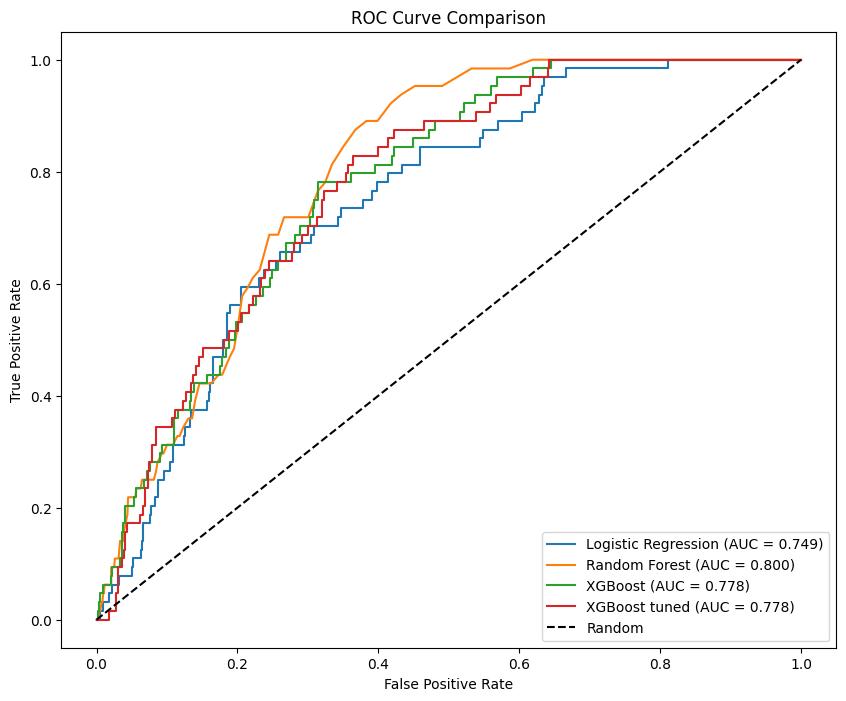

In [40]:
plt.figure(figsize=(10, 8))

# Plot ROC curve for each model
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)
fpr_best_xgb, tpr_best_xgb, _ = roc_curve(y_test, y_proba_best_xgb)

plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {lr_metrics["roc_auc"]:.3f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {rf_metrics["roc_auc"]:.3f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {xgb_metrics["roc_auc"]:.3f})')
plt.plot(fpr_best_xgb, tpr_best_xgb, label=f'XGBoost tuned (AUC = {best_xgb_metrics["roc_auc"]:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()

Model Random Forest menunjukkan kinerja terbaik dengan AUC tertinggi yaitu 0.800, mengindikasikan kemampuan yang lebih baik dalam membedakan antara dua kelas dibandingkan model lainnya. Garis putus-putus diagonal merepresentasikan pengklasifikasi acak (AUC = 0.5), yang mana semua model berkinerja jauh lebih baik darinya.

10. Feature Importance

Pada tahap ini, kita akan memvisualisasikan fitur-fitur yang paling penting dalam model Random Forest (Model dengan performa terbaik).

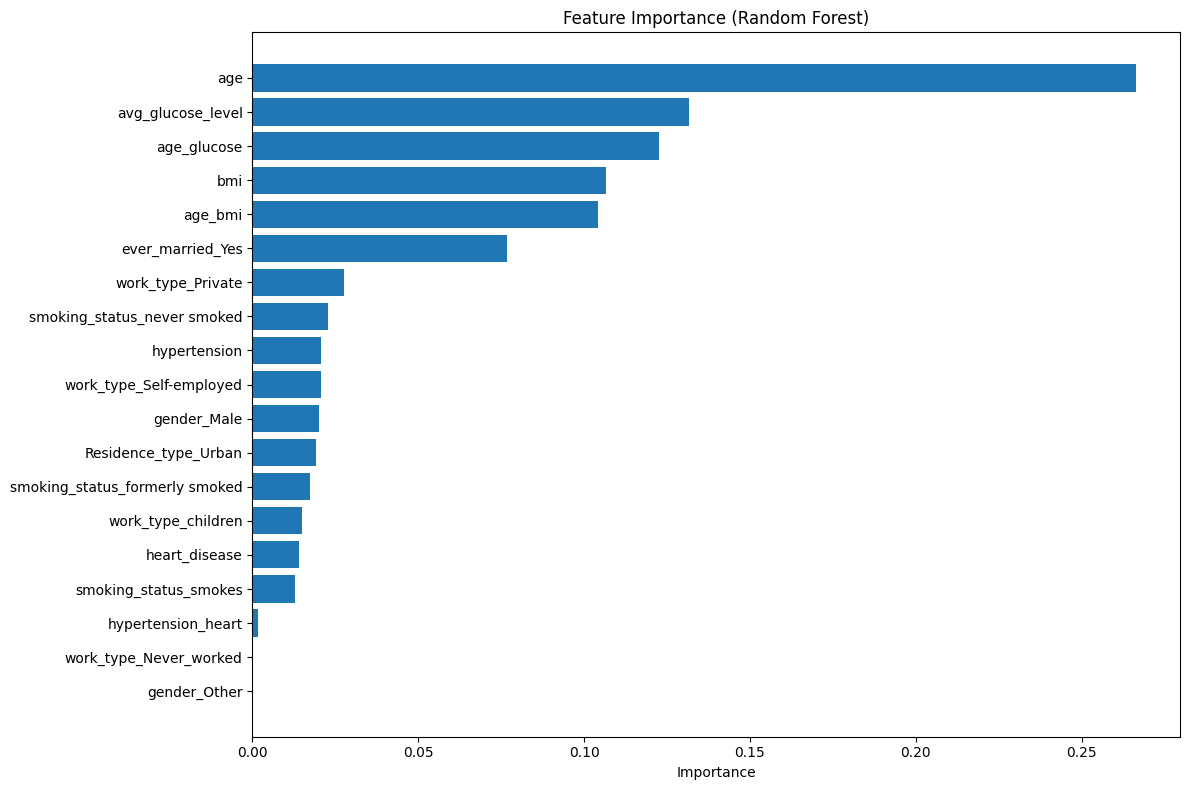

In [41]:
plt.figure(figsize=(12, 8))
feature_importance = rf.feature_importances_

sorted_idx = np.argsort(feature_importance)
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx])
plt.yticks(range(len(sorted_idx)), X.columns[sorted_idx])
plt.title('Feature Importance (Random Forest)')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

Berdasarkan visualisasi Feature Importance dari model Random Forest, dapat dilihat bahwa usia dan kadar glukosa rata-rata adalah dua faktor yang paling berpengaruh dalam memprediksi risiko stroke. Hal ini mengindikasikan bahwa intervensi pada faktor-faktor ini mungkin memiliki dampak terbesar dalam mengurangi risiko stroke.